# Tuning curves

In this notebook, we make the tuning curves for the NMF factors on synthetic blocks of solid color in the "Implementation/Black-and-white and color factors" section of the BW vs. color article.

In [1]:
import numpy as np
import torch
import torchvision
from lucent.modelzoo import inceptionv1

In [2]:
model = inceptionv1(pretrained=True)

## NMF factors

As a first step, we'd better get the NMF factors. This section is copied from the one in the weight visualizations notebook.

In [6]:
from lucid.misc.io import collapse_channels
from lucid.misc.channel_reducer import ChannelReducer

In [4]:
BW_units = [5, 9, 12, 16, 18, 22, 28, 30, 31] 
BW_edge_units = [5, 9, 16, 18, 22, 31] 
BW_point_units = [12, 28]
BW = [30]
all_units = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]

In [5]:
mixed3a_5x5 = model.mixed3a_5x5_pre_relu_conv.weight.detach().numpy()
mixed3a_5x5_bottleneck = model.mixed3a_5x5_bottleneck_pre_relu_conv.weight.detach().numpy()
weights = np.reshape(np.tensordot(mixed3a_5x5, mixed3a_5x5_bottleneck, axes=((1),(0))),(32,5,5,192))

In [7]:
W_2d_3a = weights.transpose(1,2,3,0).reshape(5,5,192,32)

In [8]:
# "Hyperparameters"

n_components = 2
units = BW_units
N = len(units)

In [9]:
W_ = W_2d_3a[..., units].transpose(-1, 0, 1, 2) 
W_posneg = np.concatenate([np.maximum(0, W_), np.maximum(0, -W_)], axis=0) 

NMF = ChannelReducer(n_components)

W_nmf = NMF.fit_transform(W_posneg)
W_nmf /= W_nmf.max()
H = NMF.components

## Activation microscope

We also want to be able to record the (post-ReLU) activations of the conv2d2 channels on various inputs.

In [10]:
class SaveFeatures_postrelu():
    features = None
    def __init__(self, model):
        for name, module in model.named_modules():
            if name == 'conv2d2': 
                self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output 
    def close(self):
        self.hook.remove()

## Tuning curves

Having set things up, let's make the tuning curve figures that we want.

### Setting up the dataset

We can set up hue x brightness, hue x saturation datasets using built-in functions from the colorsys module.

In [11]:
from colorsys import hls_to_rgb
from colorsys import rgb_to_hls

In [12]:
size = 30

Here's hue x brightness:

In [13]:
hl = np.zeros((size, size, 3))
for i in range(size):
    for j in range(size):
        hl[i,j] = hls_to_rgb(i/(size-1), j/(size-1), 1)

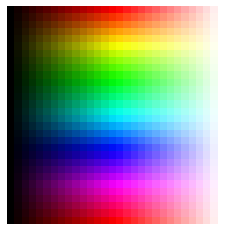

In [14]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(1,1))
plt.axis('off')
plt.imshow(hl)
plt.show()

... and hue x saturation.

In [15]:
hs = np.zeros((size, size, 3))
for i in range(size):
    for j in range(size):
        hs[i,j] = hls_to_rgb(i/(size-1), 0.5, j/(size-1))

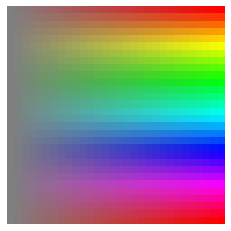

In [16]:
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(hs)
plt.show()

### Recording the activations

Next, we store the activations of the NMF factors on the (size x size) color grids.

We'll store them for both the mean channel activation and the activation of the centermost neuron. The latter turns out to be more representative because it lets us avoid edge effects (e.g. the mean activation for neurons 10 through 46 is significantly different than across neurons 0 to 56 in these examples).

In [17]:
tuningcurvehl = np.zeros((2,size,size,2))
tuningcurvehs = np.zeros((2,size,size,2))

In [18]:
for i in range(size):
    for j in range (size):
        images = torch.zeros([1, 3, 224, 224])
        images[:,0,:,:] = hl[i,j,0]
        images[:,1,:,:] = hl[i,j,1]
        images[:,2,:,:] = hl[i,j,2]
        probe = SaveFeatures_postrelu(model)
        out = model(images)
        probe.close()
        # Take the average over each channel
        conv2d2_activations_channel = torch.mean(probe.features[0,:,:,:], (1,2)).detach().numpy()
        # Alternatively, can look at the activation of the centermost neuron (also a 192-dim. vector).
        conv2d2_activations_neuron = probe.features[0,:,28,28].detach().numpy()
        tuningcurvehl[0,i,j,0] = np.inner(conv2d2_activations_channel, H[0])
        tuningcurvehl[0,i,j,1] = np.inner(conv2d2_activations_neuron, H[0])
        tuningcurvehl[1,i,j,0] = np.inner(conv2d2_activations_channel, H[1])
        tuningcurvehl[1,i,j,1] = np.inner(conv2d2_activations_neuron, H[1])

In [19]:
for i in range(size):
    for j in range (size):
        images = torch.zeros([1, 3, 224, 224])
        images[:,0,:,:] = hs[i,j,0]
        images[:,1,:,:] = hs[i,j,1]
        images[:,2,:,:] = hs[i,j,2]
        probe = SaveFeatures_postrelu(model)
        out = model(images)
        probe.close()
        # Take the average over each channel
        conv2d2_activations_channel = torch.mean(probe.features[0,:,:,:], (1,2)).detach().numpy()
        # Alternatively, can look at the activation of the centermost neuron (also a 192-dim. vector).
        conv2d2_activations_neuron = probe.features[0,:,28,28].detach().numpy()
        tuningcurvehs[0,i,j,0] = np.inner(conv2d2_activations_channel, H[0])
        tuningcurvehs[0,i,j,1] = np.inner(conv2d2_activations_neuron, H[0])
        tuningcurvehs[1,i,j,0] = np.inner(conv2d2_activations_channel, H[1])
        tuningcurvehs[1,i,j,1] = np.inner(conv2d2_activations_neuron, H[1])

### Displaying the activations

We'd like to display the activations in the same format as in OpenAI Microscope, i.e. as a hue-brightness or hue-saturation grid of squares with gray borders, where we fade the squares with smaller activations. We can do this by explicitly making an image with borders and appending a fourth column to the RGB values for %transparency based on the activations.

In [20]:
sq_size = 40
gray = (0.3,0.3,0.3) # The color of the borders.

In [21]:
def activation_plot(data, tuningcurve):
    
    # Data is a (size, size, 3) array of synthetic data that we're using: either hue-brightness or hue-saturation.
    # tuningcurve is a (size, size) array of unnormalized activations on the data.
    
    # Normalize the data to (0,1) to create a mask that we'll use to fade squares out by.
    mask = np.zeros((size,size))
    mask = (tuningcurve - np.min(tuningcurve)) / np.max(tuningcurve)
    
    # Make a plot with borders around each color.
    grid = np.zeros((size*sq_size, size*sq_size, 4))

    for i in range(size):
        for j in range(size):
            grid[i*sq_size:(i+1)*sq_size,j*(sq_size):(j+1)*sq_size,:3] = data[i,j]
            grid[i*sq_size:(i+1)*sq_size,j*sq_size,:3]= gray
            grid[i*sq_size:(i+1)*sq_size,(j+1)*sq_size-1,:3]= gray
            grid[i*sq_size,j*sq_size:(j+1)*sq_size,:3]= gray
            grid[(i+1)*sq_size-1,j*sq_size:(j+1)*sq_size,:3]= gray
    
    for i in range(size):
        for j in range(size):
            grid[i*sq_size:(i+1)*sq_size,j*(sq_size):(j+1)*sq_size,3] = mask[i,j]
            
    return grid

With that, here are the tuning curves.

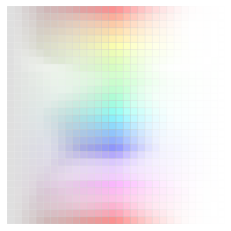

In [22]:
test = activation_plot(hl,tuningcurvehl[0,:,:,1])
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(test)
plt.show()

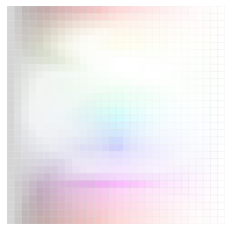

In [23]:
test = activation_plot(hl,tuningcurvehl[1,:,:,1])
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(test)
plt.show()

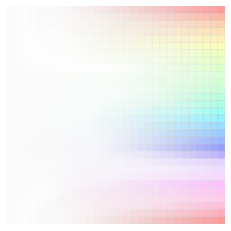

In [24]:
test = activation_plot(hs,tuningcurvehs[0,:,:,1])
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(test)
plt.show()

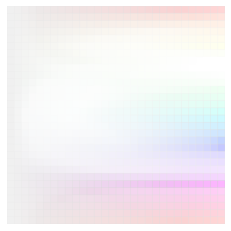

In [25]:
test = activation_plot(hs,tuningcurvehs[1,:,:,1])
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(test)
plt.show()

### Appendix: Check of normalization

Since normalizations are important in this experiment, let's do a sanity check to make sure that we can reproduce results in the OpenAI microscope for a selection of conv2d2 channels that seem especially close to being "single-color detectors." 

Here's a hue/brightness plot for channel conv2d2:23:

In [26]:
tuningcurvehl_23 = np.zeros((size,size))

In [27]:
for i in range(size):
    for j in range (size):
        images = torch.zeros([1, 3, 224, 224])
        images[:,0,:,:] = hl[i,j,0]
        images[:,1,:,:] = hl[i,j,1]
        images[:,2,:,:] = hl[i,j,2]
        probe = SaveFeatures_postrelu(model)
        out = model(images)
        probe.close()
        tuningcurvehl_23[i,j] = torch.mean(probe.features[0,23,28,28]).detach().numpy()

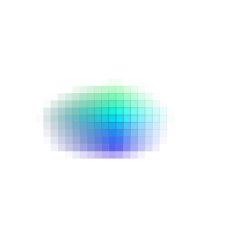

In [28]:
test = activation_plot(hl, tuningcurvehl_23)
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(test)
plt.show()

And for channel conv252:155:

In [29]:
tuningcurvehl_155 = np.zeros((size,size))

In [30]:
for i in range(size):
    for j in range (size):
        # Construct solid block input of that color from our rgb table.
        images = torch.zeros([1, 3, 224, 224])
        images[:,0,:,:] = hl[i,j,0]
        images[:,1,:,:] = hl[i,j,1]
        images[:,2,:,:] = hl[i,j,2]
        # Record the activations of conv2d2 on that input.
        probe = SaveFeatures_postrelu(model)
        out = model(images)
        probe.close()
        tuningcurvehl_155[i,j] = torch.mean(probe.features[0,155,28,28]).detach().numpy()

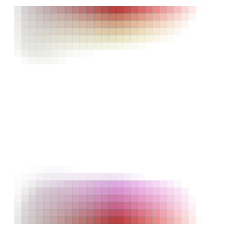

In [31]:
test = activation_plot(hs,tuningcurvehl_155)
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(test)
plt.show()

This seems to be in order.